# Implementación del algóritmo genético en N-D

Para comenzar, se importa de la librería de numpy para poder trabajar con arreglos y random para los numeros aleatorios

In [3]:
# Manejo de arreglos y operaciones matematicas
import numpy as np

# Importar funciones
import import_ipynb
from utils import FuncionesObjetivo as f

# Numeros aleatorios
import random

## Definir hiperparámetros para el algoritmo

In [2]:
# +++++++++++++++++++++++++++++++++++++ HIPERPARAMETROS +++++++++++++++++++++++++++++++++++++
r_cross = 0.9
r_mut= 0.25
resolucion = 16  # Resolución de bits con la que se trabajará
n_dims = 1  # Número de dimensiones 
n_part = 100  # Número de particulas
max_gen = 200  # Numero maximo de generaciones
rango = [[-1, 1]]
f_obj = f.f_spherical
seleccion = []
mutacion = []
cruzamiento = []

## Implementación de funciones

### Funciones generales

Ahora se implementan funciones necesarias para el algoritmo, como la funcion objetivo, funcion de selección, función para mutación, etc.

In [4]:

# funcion para convertir binarios a entero
def bin2int(pop):
    """
    Esta funcion convierte los valores binarios de la población a enteros
    input: valores binarios de la población
    output: valores enteros de la población
    """
    # Lista para guardar los valores enteros de la poblacion
    pop_entero = [] 
    # Convertir a entero cada particula de la poblacion
    for particle in pop:
        # Lista temporal para guardar los valores de cada dimension convertida a entero
        temp = []
        # Se usa un for para convertir todas las dimensiones de binario a entero
        for dim in range(n_dims):
            # variable auxiliar para ir guardando el valor de la suma de cada bit para cada dimension
            sum = 0
            # En el siguiente for cada bit se multiplica por la potencia de dos correspondiente
            for idx, n in enumerate(range(resolucion-1, -1, -1)):
                sum += particle[idx + resolucion * dim] * 2 ** n
            # Guardare el valor de la suma de la dimension en la lista temporal
            temp.append(sum)
        # Guardar el valor entero temporal en la lista de enteros
        pop_entero.append(temp)
    return np.array(pop_entero)

# Funcion para mapear el numero entero al valor decodificado
def mapeo(pop_entero, rango: list = [[-1, 1]]):
    """
    Esta funcion realiza el mapeo de un numero entero a un valor decodificado en el rango dado
    input: lista de los numeros enteros a mapear y lista de listas con el rango en el que se mapeará cada variable
    si solo se inserta un rango, se asume el mismo rango para todas las variables, el default es de -1 a 1
    output: lista con los valores decodificados
    """
    
    # Mapear cada variable a su rango correspondiente
    # Si solo hay un rango dado se asume el mismo rango para todas las variables
    if len(rango) == 1:
        # Variable para ir guardando los mapeos
        pop_decoded = []
        for i, rango_dim in enumerate(rango * n_dims): 
            # primero se obtiene la ecuación para mapear los numeros esta es la ecuación de una recta ya que es un mapeo lineal
            m = (rango_dim[1] - rango_dim[0]) / (val_max)
            # mapear los valores
            decoded = m * pop_entero[:, i] + rango_dim[0]
            pop_decoded.append(decoded)
    
    # Si hay un rango para cada variable se toma ese rango
    else:
        # Variable para ir guardando los mapeos
        pop_decoded = []
        for i, rango_dim in enumerate(rango): 
            # primero se obtiene la ecuación para mapear los numeros esta es la ecuación de una recta ya que es un mapeo lineal
            m = (rango_dim[1] - rango_dim[0]) / (val_max)
            # mapear los valores
            decoded = m * pop_entero[:, i] + rango_dim[0]
            pop_decoded.append(decoded)

    return np.array(pop_decoded).T

# Funcion para evaluar el fitness de las particulas
def eval_fitness(f_obj, decoded):
    """
    Esta funcion evalua el fitness de los valores dados con la funcion objetivo definida
    input: string con el nombre de la funcion y lista con los valores decodificados
    output: lista con la evaluación del fitness en la funcion objetivo
    """
    return f_obj(decoded)

# Funcion para realizar la selección por torneo
def torneo(pop, fitness_pop):
    """
    Esta funcion realiza la seleccion por torneo
    input: poblacion y el fitness de cada particula
    output: lista con las partitcuas seleccionadas
    """
    # lista para guardar a los ganadores
    pop_sel = []
    # Realizar un torneo por cada particula en la poblacion
    for i in range(n_part):
        # obtener los fitness de los elegidos para competir
        competidores = random.sample(range(n_part), 3)  # Se eligen 3 competidores con random.sample
        fitness_torneo = fitness_pop[competidores]  
        # Obtener el indice de la particula con mejor fitness
        idx_ganador = np.argmin(fitness_torneo)
        # Seleccionar la particula con ese fitness
        ganador = pop[competidores[idx_ganador]]
        pop_sel.append(ganador)
    return np.array(pop_sel)

# Funcion para realizar el cruzamiento y la mutacion
def cross_mut(pop_nueva):
    """
    Esta funciónn realiza el cruzamiento de la población y la mutacion
    input: población en la que se realizara el cruzamiento y mutacion
    output: población con el cruzamiento y la mutacion
    """
    # Lista para guardar las particlulas con el cruzamiento
    pop_cross = []
    # Tomar particulas de dos en dos para el cruzamiento
    for i in range(0, n_part, 2):
        # Hacer el cruzamiento solo si la probabilidad
        if random.random() <= r_cross:
            # Obtener la posición del cruzamiento
            pos = random.randint(1, (n_dims * resolucion)-2)
            # particula 1 con cruzamiento
            part1 = np.concatenate((pop_nueva[i, :pos], pop_nueva[i+1, pos:]))
            # particula 2 con cruzamiento
            part2 = np.concatenate((pop_nueva[i+1, :pos], pop_nueva[i, pos:]))
        else:  # si no hay cruzamiento las particulas quedan igual
            part1 = pop_nueva[i]
            part2 = pop_nueva[i+1]
        
        # Ahora se realiza la mutación de las dos particulas obtenidas despues del cruzamiento
        for j in [part1, part2]:
            # Hacer la mutación de cada bit
            for k, bit in enumerate(j):
                # Si está dentro de la probabilidad se muta el bit
                if random.random() <= r_mut:
                    # Invertir el valor del bit para mutar
                    j[k] = 1 - bit
        
        pop_cross.append(part1)
        pop_cross.append(part2)
        
    return np.array(pop_cross)


## Implementación del algoritmo

Una vez que ya se tienen todas las funciones necesarias ahora se llaman estas funciones dentro de un bucle para entrenar varias generaciones

El óptimo está en [-0.025] con un fitness de 0.0006
Obtenido en la generación 1


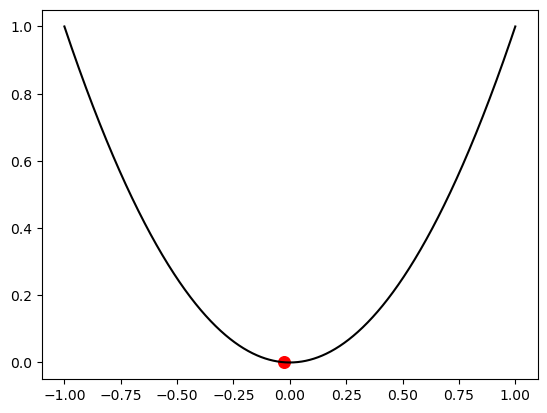

In [7]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# La población se define aleatoriamente de acuerdo con el número de dimensiones y la resolución
pop = np.random.randint(0, high=2, size=(n_part, n_dims * resolucion))
# valor maximo que se puede obtener con la resolución dada de la población
val_max = 2 ** resolucion - 1
gen = 0
# tolerancia para detener el algoritmo
tol = 1e-3
# Definimos un mejor fitness grande para iniciar el algoritmo
mejor_fitness= np.infty

# Seguir con el algoritmo mientra sean menos de 100 generaciones o el fitness sea menor a 0.001
while((mejor_fitness > tol) and (gen < max_gen)):
    # Primero se convierte la población en binario a entero
    pop_int = bin2int(pop)
    # Luego se mapean esos enteros al rango dado
    pop_decoded = mapeo(pop_int, rango=rango)
    # Se evalua el fitness de la población
    pop_fitness = eval_fitness(f_obj, pop_decoded)
    # Obtener el mejor fitness de la poblacion
    mejor_fitness_pop = np.min(pop_fitness)
    # Si el mejor fitness de la poblacion es menor al mejor fitness global se actualiza este
    if mejor_fitness_pop < mejor_fitness:
        mejor_fitness = mejor_fitness_pop
        # Obtener la particula con el mejor fitness
        part_opt = pop[np.argmin(pop_fitness)]
        decoded_opt = mapeo(bin2int([part_opt]), rango=rango)[0]
        fitness_opt = eval_fitness(f_obj, mapeo(bin2int([part_opt]), rango=rango))[0]
    # Se realiza la seleccion por torneo
    pop_nueva = torneo(pop, pop_fitness)
    # Se realiza el cruzamiento y mutacion, esta será la nueva población
    pop = cross_mut(pop_nueva)
    gen += 1
    
# Una vez concluido el algoritmo se muestran los resultados
print(f"El óptimo está en {np.around(decoded_opt, 3)} con un fitness de {fitness_opt:0.4f}")
print(f"Obtenido en la generación {gen}")

# Graficar la funcion con su minimo
f.graficar(f_obj, rango=rango, n_dims=n_dims, min=list(decoded_opt)+[fitness_opt])

En la parte de arriba poder definir todo y eleigr: funcion, metodo de seleccion, mutaacion y cruzamiento, ademas de rango

Hecho:
- Poder graficar en 2 y 3d
- Graficar minimo

Para cuando vuelva:
- Provar todas las graficas en 2 y 3d
- Poder elegir metodo de seleccion
- Mutacion
- Cruzamiento